# ARCHAEA

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
# import packages
import os
import dokdo
import qiime2 as q2
import pandas as pd
import matplotlib.pyplot as plt
from qiime2.plugins import feature_classifier
from qiime2.plugins import feature_table
from qiime2.plugins.taxa.visualizers import barplot
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.taxa.methods import filter_seqs
from qiime2.plugins.metadata.visualizers import tabulate

In [3]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [4]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [5]:
feature_table.visualizers.summarize(
    table = denoisetable,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 97354294-e6b3-48e3-bb74-4433d3db6387>

## TAXONOMIC ANALYSIS

In [6]:
# load classifier data, archaea classifier classifier-A-SSU1ArF_SSU520R
classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-A-SSU1ArF_SSU520R.qza')
reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_SSU1ArF_SSU520R.qza')
reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [7]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [8]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [9]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [10]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [11]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: ddd95c3c-c4b6-4af5-816f-cea51be621a2>

In [12]:
# choose a classifier
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [13]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: d0f6fc8c-0033-4417-8e42-7ddcfab3b157>

In [14]:
# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: 6e57333c-e311-42f1-a58c-4d316c47ee51>

### FILTER BY TAXONOMY

In [15]:
# filter denoisetable, keep only d_Archaea
denoisetable_ar = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Archaea'
)
denoisetable_ar.filtered_table.save('./results/denoisetable_ar.qza')

'./results/denoisetable_ar.qza'

In [16]:
# filter rep_seqs, keep only d_Archaea

rep_seqs_ar = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Archaea'
)
rep_seqs_ar.filtered_sequences.save('./results/rep_seqs_ar.qza')

'./results/rep_seqs_ar.qza'

### TAXA PER SPECIMEN

In [17]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_ar.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [18]:
denoise_df

,P05A,P09A,P13A,P15A,P17A,P22A
id,,,,,,
0eea051b7d547c0377a385e1a95c3893,0.0,0.0,0.0,0.0,0.0,1416.0
5d475f1c4ca43de7f1db4beccd9e922a,0.0,0.0,9011.0,0.0,0.0,0.0
25422b301a06f7bd685f1731770016ec,0.0,0.0,0.0,0.0,0.0,1906.0
cac7f5dd165d37587931bb350f560db9,0.0,0.0,31.0,0.0,0.0,0.0
b5d89f5cf0ddc1eb17fbafe964a4f672,70.0,0.0,0.0,0.0,0.0,0.0
8c9cce9b5a4857bc9cc3c39204799426,0.0,0.0,0.0,0.0,0.0,3990.0
93ec640b7aa0f0dce5aee7ffc053a2b6,0.0,0.0,0.0,49.0,0.0,0.0
434fd18ef5bfd598797a8f7f4dc050be,0.0,24.0,0.0,0.0,0.0,0.0
f9abde7ffb072b2be31cb2dbb39f9426,0.0,0.0,0.0,0.0,51.0,0.0


In [19]:
# define functions
# define extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

# define backtrace_unassigned 
def backtrace_unassigned(row, unassigned_like_words, invalid_words):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        valid_name = [val for val in row[columns].values if val not in invalid_words][-1]
        row[columns] = [val if val not in invalid_words else f"Unclass._{valid_name}" for val in row[columns].values]
        
        valid_name = [val for val in row[columns].values if val not in unassigned_like_words][-1]
        row[columns] = [val if val not in unassigned_like_words else f"Unclass._{valid_name}_{val}" for val in row[columns].values]
    except:
        pass
    return row

# define reassemble taxon column
def reassemble_taxon(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    prefixes = ['d__', 'p__', 'c__', 'o__', 'f__', 'g__']
    return ";".join(["".join(pair) for pair in zip(prefixes, row[columns].values)])


In [20]:
# run once for each sample (subject)
# choose a sample 
subject = 'P22A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))
#custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

invalid_words = ['metagenome', 'uncultured_euryarchaeote', 'uncultured_archaeon',"Unassigned"]
unassigned_like_words = [ 'Marine_Group_II']
custom_df = custom_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon, axis=1)


columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']#, 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
print(taxa_per_species.to_latex(escape=False))

#taxa_per_species

\begin{tabular}{lllllr}
\toprule
                 &                  &                  &                  &                  &    P22A \\
Phylum & Class & Order & Family & Genus &         \\
\midrule
Nanoarchaeota & Nanoarchaeia & Woesearchaeales & Woesearchaeales & Woesearchaeales &  3322.0 \\
Unclass._Archaea & Unclass._Archaea & Unclass._Archaea & Unclass._Archaea & Unclass._Archaea &  3990.0 \\
\bottomrule
\end{tabular}



### VISUALIZATIONS

In [21]:
# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Domain'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ['metagenome', 'uncultured_euryarchaeote', 'uncultured_archaeon', "Unassigned"]
unassigned_like_words = [ 'Marine_Group_II']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon, axis=1)

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [22]:
new_taxonomy.view(view_type = pd.DataFrame)

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
2ac5ece8b45328cf319e3d2dde988883,d__Eukaryota;p__Heterolobosea;c__Tetramitia;o_...,0.9999999999987026,Eukaryota,Heterolobosea,Tetramitia,Tetramitia,Tetramitia,Naegleria
5d475f1c4ca43de7f1db4beccd9e922a,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9998461178409673,Archaea,Thermoplasmatota,Thermoplasmata,Unclass._Thermoplasmata_Marine_Group_II,Unclass._Thermoplasmata_Marine_Group_II,Unclass._Thermoplasmata_Marine_Group_II
5fd89c0226473f4cf26fa26e15aaa763,d__Bacteria;p__Unclass._Bacteria;c__Unclass._B...,0.7746433568454731,Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria
7552b285840ebdd0b1d71778c2e10446,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.44345505448816747,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
0efba06ead52484fb83cbe9fdaa53a8d,d__Bacteria;p__Unclass._Bacteria;c__Unclass._B...,0.7221020273250013,Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria
...,...,...,...,...,...,...,...,...
6393e4ed57f383ae6eef479dc80334eb,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.4567079883015408,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
52828153d53730fbc273948806794f23,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.42636235809439804,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
92bc27c5d48a567b16e106f036b22301,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.388766289358877,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned


In [33]:
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
new_taxonomy_df

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
2ac5ece8b45328cf319e3d2dde988883,d__Eukaryota;p__Heterolobosea;c__Tetramitia;o_...,0.9999999999987026,Eukaryota,Heterolobosea,Tetramitia,Tetramitia,Tetramitia,Naegleria
5d475f1c4ca43de7f1db4beccd9e922a,d__Archaea;p__Thermoplasmatota;c__Thermoplasma...,0.9998461178409673,Archaea,Thermoplasmatota,Thermoplasmata,Unclass._Thermoplasmata_Marine_Group_II,Unclass._Thermoplasmata_Marine_Group_II,Unclass._Thermoplasmata_Marine_Group_II
5fd89c0226473f4cf26fa26e15aaa763,d__Bacteria;p__Unclass._Bacteria;c__Unclass._B...,0.7746433568454731,Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria
7552b285840ebdd0b1d71778c2e10446,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.44345505448816747,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
0efba06ead52484fb83cbe9fdaa53a8d,d__Bacteria;p__Unclass._Bacteria;c__Unclass._B...,0.7221020273250013,Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria,Unclass._Bacteria
...,...,...,...,...,...,...,...,...
6393e4ed57f383ae6eef479dc80334eb,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.4567079883015408,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
52828153d53730fbc273948806794f23,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.42636235809439804,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned
92bc27c5d48a567b16e106f036b22301,d__Unassigned;p__Unassigned;c__Unassigned;o__U...,0.388766289358877,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned,Unassigned


In [44]:
# subset that contains certain string
#dfx = df2[df2['Class'].str.contains('Unclass.', na = False)]
new_taxonomy_df['Domain'].unique()
df2=new_taxonomy_df.query("Domain == 'Archaea'")
#f2['Phylum'].unique()
# subset that doesn't contain certain string
df3 = df2[df2["Class"].str.contains('Unclass.')==False]
#f3['Class'].unique()
df4 = df3[df3["Order"].str.contains('Unclass.')==False]
#df4['Order'].unique()

array(['Woesearchaeales'], dtype=object)

In [23]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_ar.filtered_table,
    taxonomy = new_taxonomy,
    metadata = sample_metadata
).visualization

In [24]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

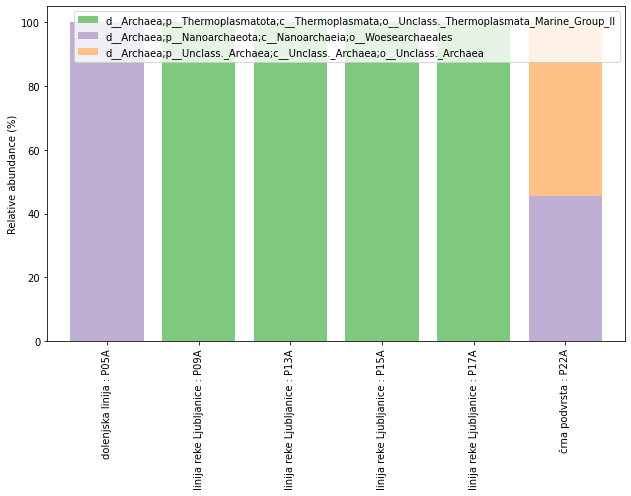

In [25]:
# taxa abundance plot with dokdo
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    level=4,
    count=8,
    figsize=(9, 7),
    by=['population'],
    label_columns=['population', 'sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

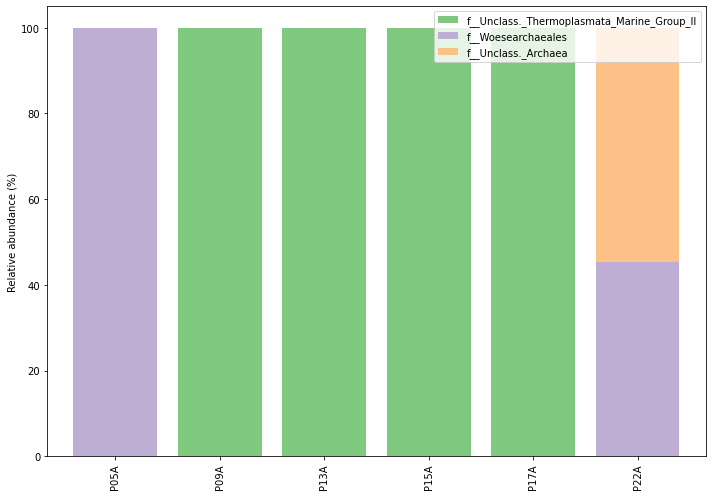

In [26]:
# show 7 most abundant genera plus 'Others' with count = 8
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(10, 7),
    level=5,
    count=8,
    legend_short=True,
    by=['year'],
    label_columns=['sample-id'],
    sort_by_mean2=False
)

plt.tight_layout()

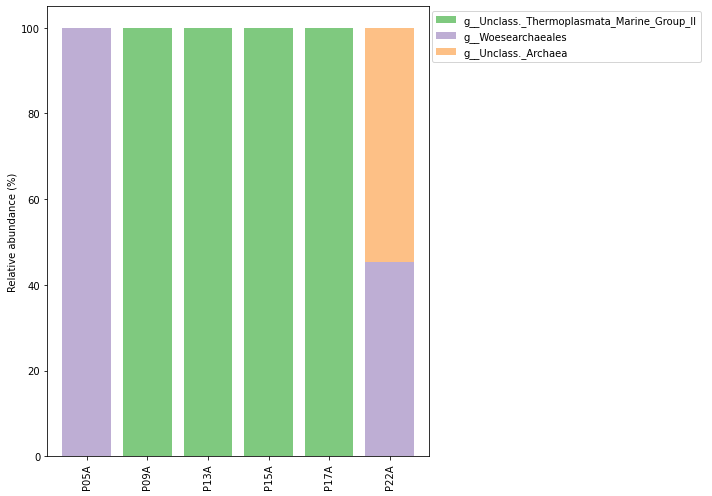

In [27]:
# plot the legent separately
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=10,
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=10,
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

plt.tight_layout()

In [28]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

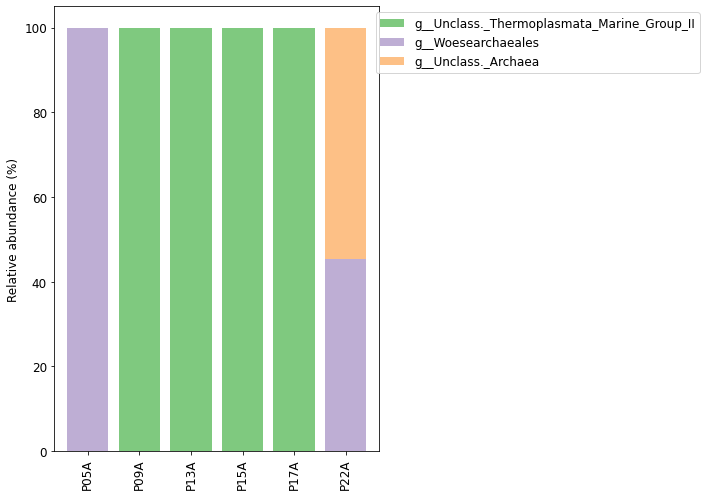

In [29]:
# use a different colour map
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=17,
    cmap_name='Accent',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=17,
    cmap_name='Accent',
    legend_short=False
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

# custom properties
ax1.tick_params(labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(12)


ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

plt.tight_layout()
plt.savefig('./results/proteus_all_16taxa.png')

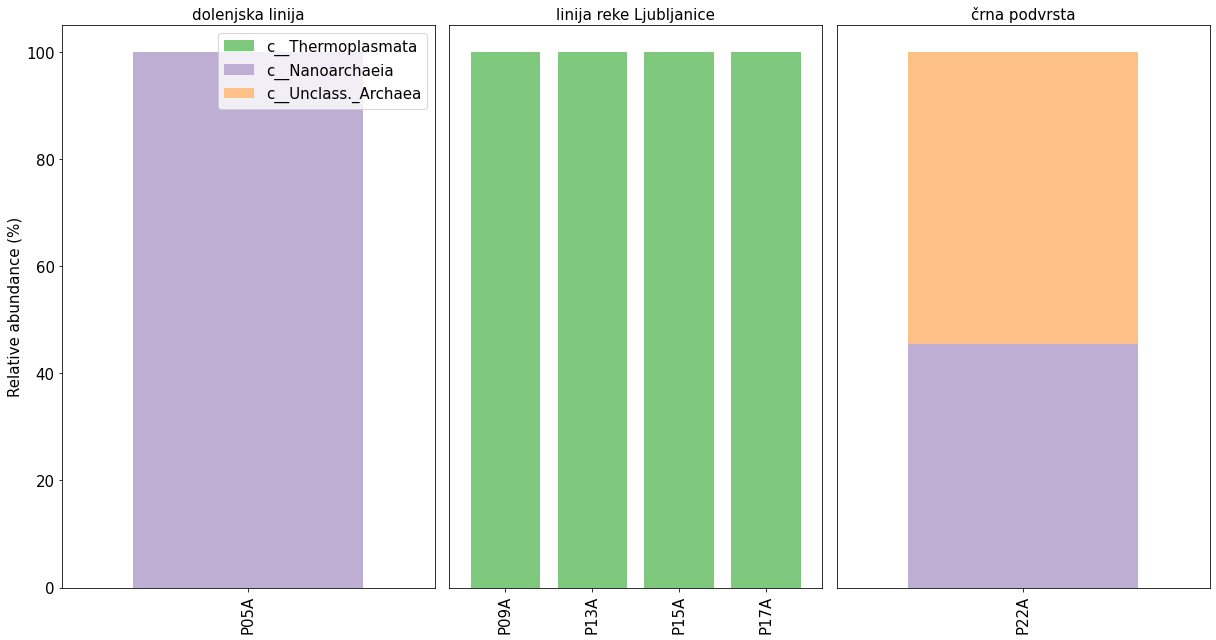

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(17, 9))

groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=3, count=8, sort_by_mean2=False)

for i, group in enumerate(groups):
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=axes[i],
        include_samples={'population': [group]},
        cmap_name='Accent',
        legend_short=True,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        axes[i].get_yaxis().set_visible(False)
    axes[i].set_title(group)

# custom properties
for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
    if idx == 0:
        ax.legend(fontsize=15)
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_archaea.png')

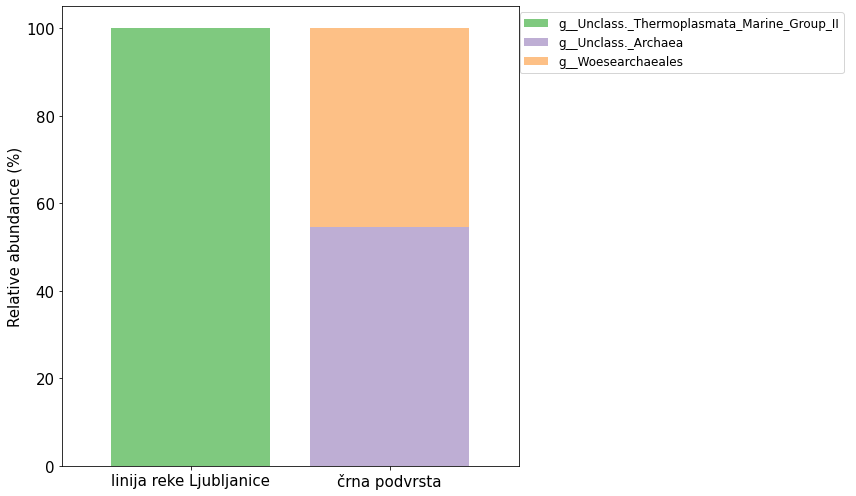

In [31]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend=False,
    cmap_name='Accent'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='Accent'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together.png')

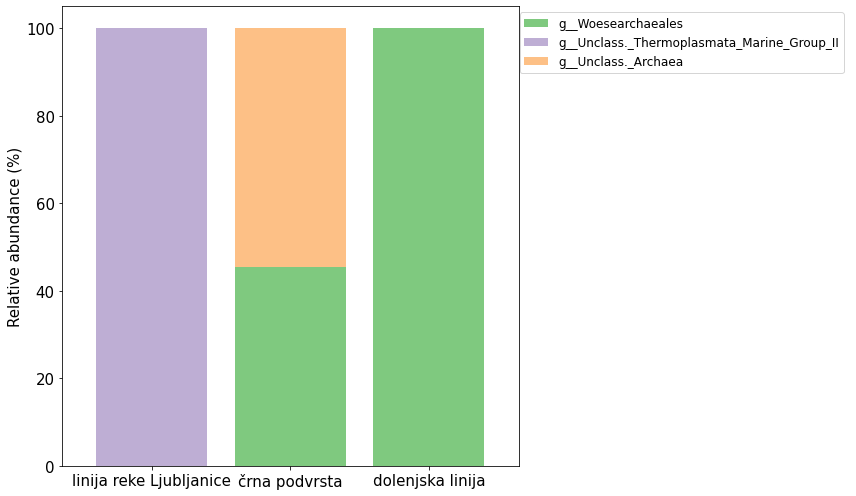

In [32]:
fig, [ax1, ax2,] = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [9, 1]})

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend=False,
    cmap_name='Accent'
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    level=6,
    count=20,
    group='population',
    group_order=['linija reke Ljubljanice', 'črna podvrsta', 'dolenjska linija'],
    figsize=(10, 7),
    legend_short=False,
    cmap_name='Accent'
)

handles, labels = ax2.get_legend_handles_labels()
labels = [label_filter(lbl) for lbl in labels]

ax2.clear()
ax2.legend(handles, labels, fontsize=12)
ax2.axis('off')

# custom properties
ax1.tick_params(labelrotation = 0, labelsize=15)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/proteus_all_populations_together_all.png')